In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score
    
import time
import warnings

import numpy as np
import pandas as pd

from sklearn import cluster, datasets, mixture
from sklearn.cluster import KMeans
from sklearn.datasets.samples_generator import make_blobs
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
from scipy.cluster import hierarchy
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Визуализация работы <a href='https://www.naftaliharris.com/blog/visualizing-k-means-clustering/'> Kmeans </a> и <a href='https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/'> DBSCAN </a>


# Пример результатов работы разных алгоритмов кластеризации

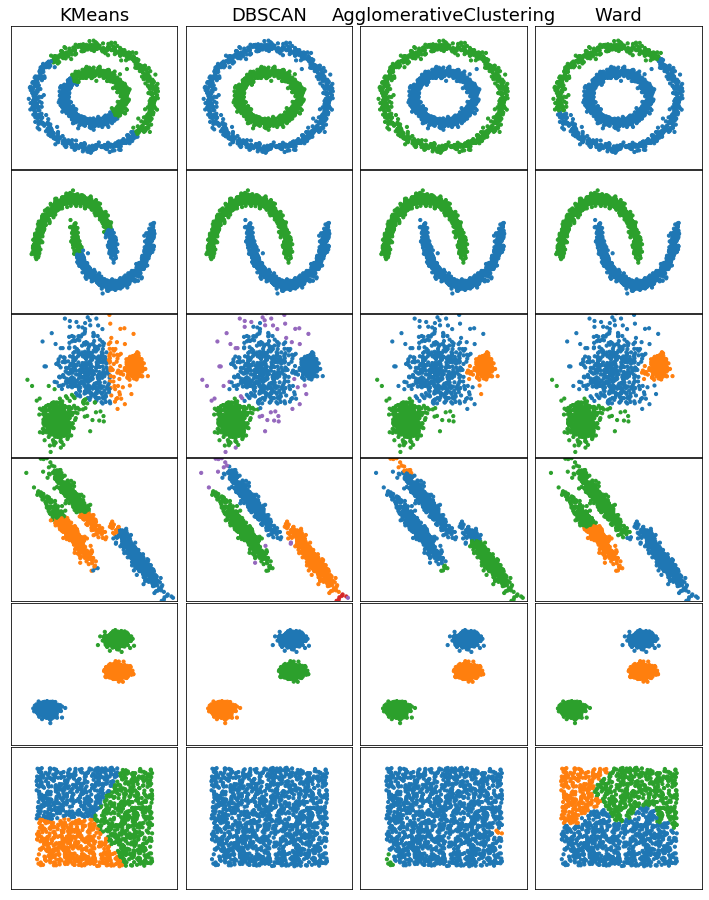

In [2]:
np.random.seed(0)

'''Сгенерируем данные'''

n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

'''Параметры кластеров'''

plt.figure(figsize=(4 * 2.5, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3}

all_datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2}),
    (aniso, {'eps': .15, 'n_neighbors': 2}),
    (blobs, {}),
    (no_structure, {})]

for i_dataset, (dataset, algo_params) in enumerate(all_datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    '''Кластеризация'''
    
    two_means = cluster.KMeans(n_clusters=params['n_clusters'])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)
    dbscan = cluster.DBSCAN(eps=params['eps'])
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)

    clustering_algorithms = (
        ('KMeans', two_means),
        ('DBSCAN', dbscan),
        ('AgglomerativeClustering', average_linkage),
        ('Ward', ward),
    )

    for name, algorithm in clustering_algorithms:

        algorithm.fit(X)

        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(all_datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(['tab:blue', 'tab:green', 'tab:orange', 'tab:red', 'tab:purple'])
        plt.scatter(X[:, 0], X[:, 1], s=10, c=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plot_num += 1

# Аггломеративная кластеризация

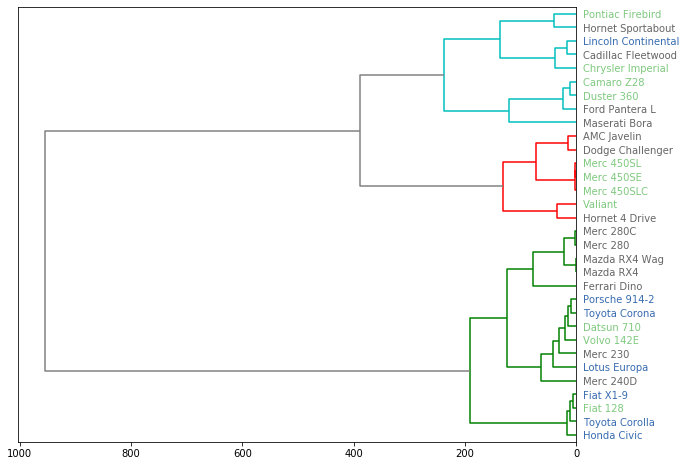

In [3]:
df = pd.read_csv('https://python-graph-gallery.com/wp-content/uploads/mtcars.csv')
df = df.set_index('model')
del df.index.name
# df
 
# Calculate the distance between each sample
Z = hierarchy.linkage(df, 'ward')

# Plot with Custom leaves
plt.figure(figsize=(10,8))
hierarchy.dendrogram(Z, labels=df.index, leaf_rotation=0, orientation="left", 
                     color_threshold=240, above_threshold_color='grey', leaf_font_size=10);

# Create a color palette with 3 color for the 3 cyl possibilities
my_palette = plt.cm.get_cmap("Accent", 3)
 
# transforme the 'cyl' column in a categorical variable. It will allow to put one color on each level.
df['cyl']=pd.Categorical(df['cyl'])
my_color=df['cyl'].cat.codes

# Apply the right color to each label
ax = plt.gca()
xlbls = ax.get_ymajorticklabels()
num = -1
for lbl in xlbls:
    num += 1
    val = my_color[num]
    lbl.set_color(my_palette(val))